# GAN Tutorial 2

The aim of the previous notebook was to illustrate the structure and standard training method for Generative Adversarial Networks (GANs), highlighting key points in the theory of GANs and elucidating the topic with a working example, using Tensorflow and Keras to train a GAN on the MNIST dataset. In this notebook we are going to build on that work to train a GAN to generate convincing images from any given class. In order to do this we will take advantage of the class labels present in the MNIST dataset - this is crucial information and helps in the training immensely. We must restructure the GAN slightly to allow the generator and discriminator to take multiple inputs and outputs, which is remarkably simple with the Keras functional API. The structure of our GAN will be as follows:

![GAN_labelled_diagram.png](imgs_for_notebooks/GAN_labelled_diagram.png)

The generator must take random noise as input as before, but also a randomly selected class that it should generate. This means that, once trained, the generator should produce a digit from any class we choose. The discriminator will also take two inputs, the first being images, the second being corresponding class labels. This will allow the discriminator to make its decision of whether the image is real or fake not just based on how convincing the image is as a digit, but based on whether the digit belongs to the given class, which will force the generator to draw images from the correct class in order to perform well.

In [1]:
# Required modules and functions

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape, Flatten, Concatenate, BatchNormalization #Layers
from tensorflow.keras.layers import LeakyReLU #Activations
from tensorflow.keras.optimizers import Adam #Optimisers

import matplotlib.pyplot as plt
import time
import random
import tqdm

import numpy as np

In [2]:
# Setting global random seed for reproducibility
tf.random.set_seed(1234)

# Number of data features
N_FEATS = 10

# MNIST is black and white, so 1 channel
IMAGE_CHANNELS = 1

# Layout for displaying generated images 
PREVIEW_ROWS = 2
PREVIEW_COLS = 5

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 100
BATCH_SIZE = 128
BUFFER_SIZE = 60000

# Optimisers
generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)

# Path to folder
PATH = '...'

We are using the MNIST dataset provided by the tensorflow_datasets module. The data is loaded, the pixel values scaled to range between -1 and 1, the range of the tanh activation function which will be used in the last layer of the generator. The data is then shuffled and batched according to the BATCH_SIZE and BUFFER_SIZE parameters. We use Buffer size of 60,000 (length of the dataset) so that the data is fully shuffled, and a Batch size of 128. Batch size can be tweaked, but be mindful of available RAM.

In [3]:
def scale_images(imgs):
    return 2.*tf.cast(imgs, tf.float32)/255. - 1

#Loading the data    
(mnist_train, label_train), (mnist_test, label_test) = tfds.load('mnist',
                                                                 split=['train', 'test'],
                                                                 batch_size=-1,
                                                                 as_supervised=True)
# Scale
mnist_train = scale_images(mnist_train)
label_train = tf.one_hot(label_train, depth=N_FEATS)

# Shuffle and batch
dataset = tf.data.Dataset.from_tensor_slices((mnist_train, label_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

The simplicity of MNIST allows us to get to grips with GANs with a simple dense structure. We will use a generator and discriminator with 3 dense hidden layers. Since we need to generate 28 x 28 images, the final layer will have 1024 units, which can then be reshaped into the desired format. The other parameters can be played with. We will also use the standard tanh activation in the last layer, with the other layers having Leaky ReLu.

In [4]:
def create_generator():
    inputs_rand = Input(shape=(SEED_SIZE,))
    inputs_feats = Input(shape=(N_FEATS,))
    inputs = Concatenate()([inputs_rand, inputs_feats])
    
    # add the hidden layers
    x = Dense(256, activation='relu')(inputs)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=1024, activation='relu')(x)
    
    # add the output layer
    x = Dense(units=28*28, activation='tanh')(x)

    output = Reshape((28, 28, 1), input_shape=(28 * 28,))(x)
        
    generator = Model(inputs=[inputs_rand, inputs_feats], outputs=[output, inputs_feats], name='Generator')
    return generator
g=create_generator()
g.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          28416       concatenate[0][0]        

The discriminator is the mirror image of the generator. This makes sense intuitively as it is trying to undo what the generator has done. It will predict 1 for 'Real', and 0 for 'Fake', so the sigmoid activation is used in the final layer. We use Leaky ReLu in the other layers again. This helps reduce the vanishing gradients problem which affects larger GANs in particular.

In [5]:
def create_discriminator():
    inputs_img = Input(shape=(28,28,1))
    inputs_feats = Input(shape=(N_FEATS,))
    x = Flatten()(inputs_img)

    # add hidden layers
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    
    x = Concatenate()([x, inputs_feats])
    
    x = Dense(units=128, activation='relu')(x)
    
    # add output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[inputs_img, inputs_feats], outputs=[output], name='Discriminator')
    return discriminator
d =create_discriminator()
d.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         803840      flatten[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          524800      dense_4[0][0]                    
______________________________________________________________________________________

In [6]:
def create_gan(discriminator, generator):
    #discriminator.trainable=False
    gan_input_rand = Input(shape=(100,), name='Random_Input')
    gan_input_feats = Input(shape=(N_FEATS,), name='Features_Input')
    x = generator([gan_input_rand, gan_input_feats])
    gan_output= discriminator(x)
    gan= Model(inputs=[gan_input_rand, gan_input_feats], outputs=gan_output)
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Random_Input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
Features_Input (InputLayer)     [(None, 10)]         0                                            
__________________________________________________________________________________________________
Generator (Model)               [(None, 28, 28, 1),  1488912     Random_Input[0][0]               
                                                                 Features_Input[0][0]             
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            1494273     Generator[1][0]              

In [7]:
def plot_generated_images(epoch, generator, noise, feats, 
                          examples=PREVIEW_ROWS*PREVIEW_COLS, 
                          dim=(PREVIEW_ROWS, PREVIEW_COLS), 
                          figsize=(8,4)):
    
    generated_images = generator.predict([noise, feats])[0]
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')#, cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'C://Users/ewand/Jupyter Projects/GAN/Output/Images/Dense_MNIST_labelled 2/dense_gan_generated_image {epoch}.png')
    plt.show()

In [ ]:
def training(epochs=100):
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    # Compiling models, 'trainable' only used when compiling, so doing it in this order means discriminator will train
    # when discriminator.train_on_batch() is called, but not when gan.train_on_batch() is called.
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer, metrics=['accuracy'])
    
    # Use fixed noise to generate example images
    example_noise = tf.random.normal(shape=(PREVIEW_ROWS*PREVIEW_COLS, 100), mean=0, stddev=1)
    example_feats = tf.one_hot(range(10), depth=N_FEATS)
    
    plot_generated_images(0, generator, example_noise, example_feats)
    
    for e in range(1,epochs+1):
        print(f'Epoch {e}')
        for batch in tqdm.notebook.tqdm(dataset):
            
            # Generate random noise as an input for the generator.
            noise = tf.random.normal(shape=(BATCH_SIZE, 100), mean=0, stddev=1)
            feats = tf.one_hot(tf.random.uniform(shape=(BATCH_SIZE,), minval=0, maxval=9, dtype=tf.int32), depth=N_FEATS)
            
            # Generate fake images from noise.
            generated_images = generator.predict([noise, feats])
            
            # Construct different batches of  real and fake data.
            X_imgs = tf.concat([batch[0], generated_images[0]], axis=0)
            X_feats = tf.concat([batch[1], generated_images[1]], axis=0)
            #X = tf.data.Dataset.from_tensor_slices((X_imgs, X_feats))
            
            # Labels for generated and real data, discriminator should map real images to 1, fakes to 0.
            # Soft labels are supposed to improve training.
            y_dis_real = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
            y_dis_fake = tf.random.uniform(shape = (BATCH_SIZE,), minval=0, maxval=0.1)
            y_dis = tf.concat([y_dis_real, y_dis_fake], axis=0)
            
            # Train discriminator on batch first. 
            discriminator.train_on_batch([X_imgs, X_feats], y_dis)
            
            # Now we are going to train the generator to make the discriminator predict incorrectly, that is map the fakes to 1.
            #noise = tf.random.normal(shape = (BATCH_SIZE, 100), mean=0, stddev=1)
            y_gen = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
                        
            # Then training the GAN with noise as input and targets as real makes the generator try to trick the discriminator.
            # This process of adversarial training will continue until the generator produces good results.
            gan.train_on_batch([noise, feats], y_gen)
            
        plot_generated_images(e, generator, example_noise, example_feats)
    return generator, discriminator
g, d = training(EPOCHS)

tf.keras.models.save_model(g, PATH)

This model was then trained for 100 epochs as before, with the progress shown here. The generator should be producing a full sequence of digits, 0–9. It seems we have yet more success! With the exception of the digit 9, we have a convincing sequence of digits.
![MNIST_gan_labelled1.gif](imgs_for_notebooks/MNIST_gan_labelled1.gif)
![100x100.png](imgs_for_notebooks/100x100.png)

In the above grid, the images in each column are generated from the same random input, but with different class labels. It is clear that encoded within the random input is some feature in the resulting digit. For example, in the column 5 all strokes are quite thin, whereas all digits in column 8 have thick line strokes. Similarly all digits in column 2 appear to slant to the right, while those in column 3 slant slightly to the left. While these encodings would not be clear to any human trying to interpret them, it is possible to control the style of the generated digits to a certain extent by studying the behaviour of the generator on a large sample of random inputs. 

In order to demonstrate this, I have inspected the output of the generator on a large number of inputs, and sorted the inputs based on the type of output the generator produced. The categories I considered were 'thick stroke, straight', 'thick stroke, slanted right', 'thin stroke, straight' and 'thin stroke, slanted right'. Each category was then averaged, so that I had four input vectors, one for each category. When these inputs are passed through the generator, they produce new images from that category, as shown below. Here I'm showing 1s, 4s, and 8s as these digits show the most exaggerated slanting.

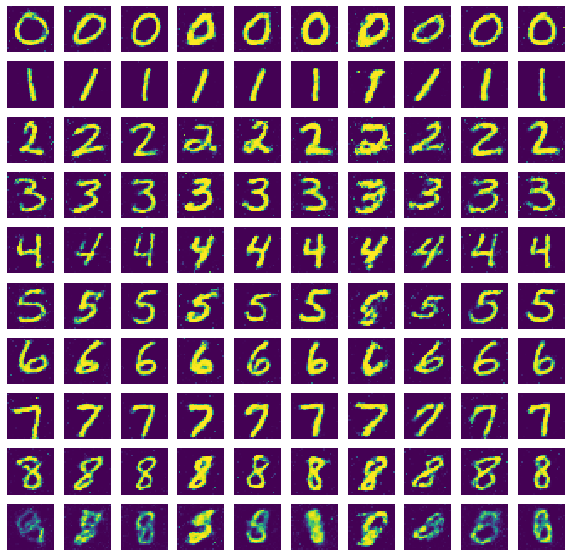

In [102]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
noises = list()
for col in range(10):
    noise = tf.random.normal(shape=(1, 100), mean=0, stddev=1)
    noises.append(noise)
    for row in range(10):
        feat = np.reshape(tf.one_hot(row, depth=10), (1,10))
        generated_image = g.predict([noise, feat])[0]
        ax[row, col].imshow(np.squeeze(generated_image))
        ax[row, col].axis('off')
        
#fig.savefig('C://Users/ewand/Jupyter Projects/GAN/Output/Images/100x100-2.png')
        

In [ ]:
thin_straight = []
thick_straight = []
thin_right = []
thick_right = []

In [73]:
thin_straight.append(noises[col])

In [99]:
thick_straight.append(noises[col])

In [72]:
thin_right.append(noises[col])

In [96]:
thick_right.append(noises[col])

In [120]:
thick_s = np.mean(thick_straight, axis=0)
thin_s = np.mean(thin_straight, axis=0)
thick_r = np.mean(thick_right, axis=0)
thin_r = np.mean(thin_right, axis=0)

In [210]:
# This function plots a column of 3 images, 1, 4 & 8. These were chosen as they show the slanting well.
def plotting_feature_coding(inputs, filepath):
    plt.figure(figsize=(6,2))
    i=1
    for digit in [1,4,8]:
        feat = np.reshape(tf.one_hot(digit, depth=10), (1,10))
        generated_image = g.predict([inputs, feat])[0]
        plt.subplot(1,3, i)
        plt.imshow(np.squeeze(generated_image))
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

Use the below code to generate a set of images, then put them together as a GIF, and see the magic happen!

In [ ]:
# This example uses thin_r, that is the input corresponding to the thin-stroke, slanting right category. Try with the others too!
i = 1
for a in np.linspace(2,-2,50):
    plotting_feature_coding(a*thin_r, os.path.join(PATH, f'{i}.png')
    i += 1

If we multiply these inputs by a number larger than 1, we can exaggerate the features of that input, and if we us a number less than one, we can reduce that feature. In fact, it seems that if we multiply by negative number we can generate digits with the reversed features! See the below gifs - they represent the output of our generator when the inputs for each category are multiplied by scalars ranging between 2 and -2. See how they start with exaggerated features of the above, and end as the reverse!

![scaling_feats.gif](imgs_for_notebooks/scaling_feat.gif)

You can even add and subtract meaningfully in this latent space. What might you expect to get if you added the input for thick, straight digits to the input for thin, slanted digits?

![add_feats.png](imgs_for_notebooks/add_feats.png)

You get an input for thick, slanted digits! And what about subtracting the input for thick, straight digits from the input for thick, slanted digits?

![sub_feats.png](imgs_for_notebooks/sub_feats.png)

You get an input for thin, slanted digits! How cool is that?

In following tutorials I will be extending the techniques we have learned thus far to training a GAN on higher-resolution images of faces, and we shall see what we see!